In [32]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_files = list(Path("../../logs/breaking_points_fainder").rglob("*.csv"))

df_latest = pd.DataFrame()

for file_path in list_of_files:
    # Read the CSV file
    temp_df = pd.read_csv(file_path)

    # Append to the main DataFrame
    df_latest = pd.concat([df_latest, temp_df], ignore_index=True)
# "timestamp,fainder_mode,filter_size_wrong,filter_size_right,filter_size,filter_size_wrong_doc,filter_size_right_doc,filter_size_doc,execution_time,execution_time_first,num_results_first,num_results,query, num_workers

df_latest["query"] = df_latest["query"].str.replace(
    r"kw\('[^']*'\)\s+AND\s+", "", regex=True
)

os.makedirs("excecution", exist_ok=True)

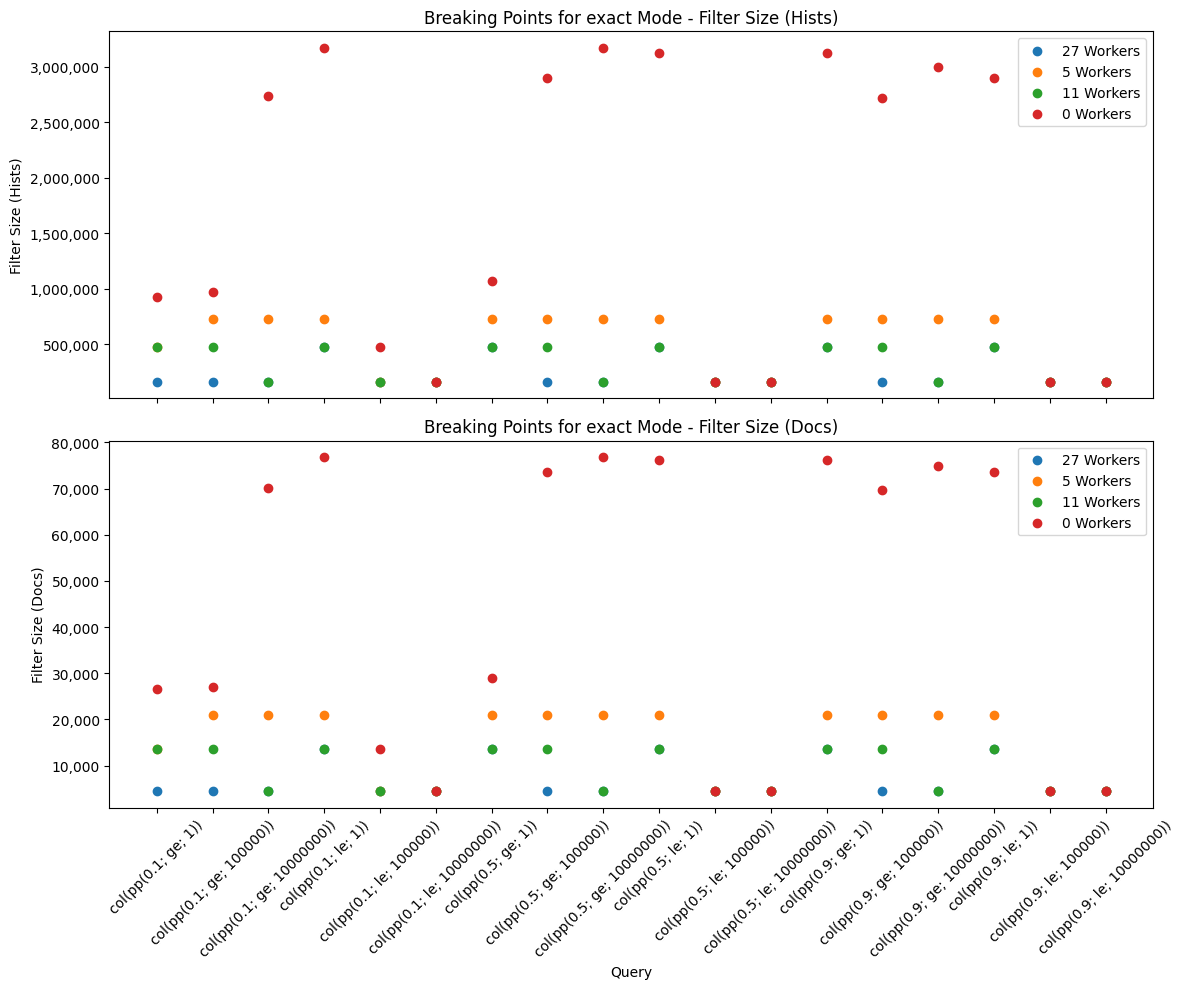

In [33]:
# plot breaking points per query per num_workers as points in two plots

fainder_modes = ["exact"]

for fainder_mode in fainder_modes:
    df_filtered = df_latest[df_latest["fainder_mode"] == fainder_mode]
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    for num_workers in df_filtered["num_workers"].unique():
        df_worker = df_filtered[df_filtered["num_workers"] == num_workers]
        # Group by query and find the max filter size
        grouped = df_worker.groupby("query")["filter_size"].max().reset_index()
        # Plotting points instead of bars
        ax1.scatter(grouped["query"], grouped["filter_size"], label=f"{num_workers} Workers")
    
    ax1.set_title(f"Breaking Points for {fainder_mode} Mode - Filter Size (Hists)")
    ax1.set_ylabel("Filter Size (Hists)")
    # Hide x-axis tick labels for the first plot
    ax1.set_xticklabels([])
    ax1.set_xlabel("")
    ax1.legend()
    
    # Format y-axis with commas
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ",")))
    
    # Only show query in the second graph
    for num_workers in df_filtered["num_workers"].unique():
        df_worker = df_filtered[df_filtered["num_workers"] == num_workers]
        # Group by query and find the max filter size for docs
        grouped = df_worker.groupby("query")["filter_size_doc"].max().reset_index()
        # Plotting points instead of bars
        ax2.scatter(grouped["query"], grouped["filter_size_doc"], label=f"{num_workers} Workers")
    
    ax2.set_title(f"Breaking Points for {fainder_mode} Mode - Filter Size (Docs)")
    ax2.set_ylabel("Filter Size (Docs)")
    ax2.set_xlabel("Query")
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    
    # Format y-axis with commas
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ",")))
    
    plt.tight_layout()
    plt.savefig(f"excecution/breaking_points_{fainder_mode}_combined.png")
    plt.show()

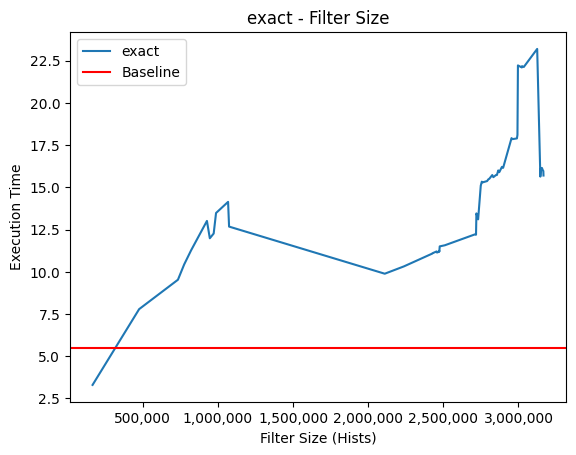

KeyError: 'fainder_mode_change'

In [34]:
# One plot for each fainder mode
# Use filter_size 0 as the baseline
# x-axis: filter_size y-axis: execution_time
# First set of plots for filter_size
fainder_modes = ["exact"]

df_baseline = df_latest[df_latest["filter_size"] == 0]
df_latest_nonzero = df_latest[df_latest["filter_size"] != 0]

for fainder_mode in fainder_modes:
    df_fainder_mode = df_latest_nonzero[
        df_latest_nonzero["fainder_mode"] == fainder_mode
    ]
    df_fainder_mode = (
        df_fainder_mode.groupby("filter_size")["execution_time"].mean().reset_index()
    )
    df_fainder_mode = df_fainder_mode.sort_values("filter_size")
    df_fainder_mode = df_fainder_mode.reset_index(drop=True)
    df_baseline_mode = df_baseline[df_baseline["fainder_mode"] == fainder_mode]

    plt.figure()
    plt.title(f"{fainder_mode} - Filter Size")
    plt.xlabel("Filter Size (Hists)")
    plt.ylabel("Execution Time")
    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ","))
    )
    plt.plot(
        df_fainder_mode["filter_size"],
        df_fainder_mode["execution_time"],
        label=fainder_mode,
    )
    plt.axhline(
        y=df_baseline_mode["execution_time"].mean(),
        color="r",
        linestyle="-",
        label="Baseline",
    )
    plt.legend()
    plt.show()

    # one plot for min, mean, max of biggest filter_size per query
    df_fainder_mode = df_latest_nonzero[
        df_latest_nonzero["fainder_mode"] == fainder_mode
    ]
    df_fainder_mode = df_fainder_mode.loc[
        df_fainder_mode.groupby("fainder_mode_change")["filter_size"].idxmax()
    ]
    df_fainder_mode.reset_index(drop=True, inplace=True)

    plt.figure()
    plt.title(f"Filter Size of the breaking point for mode: {fainder_mode}")
    plt.scatter(
        df_fainder_mode.index,
        df_fainder_mode["filter_size"],
        alpha=0.5,
        label="Data Points",
    )
    plt.axhline(
        y=df_fainder_mode["filter_size"].min(),
        color="g",
        linestyle="--",
        label=f"Min ({int(df_fainder_mode['filter_size'].min()):,})",
    )
    plt.axhline(
        y=df_fainder_mode["filter_size"].mean(),
        color="r",
        linestyle="--",
        label=f"Mean ({int(df_fainder_mode['filter_size'].mean()):,})",
    )
    plt.axhline(
        y=df_fainder_mode["filter_size"].max(),
        color="b",
        linestyle="--",
        label=f"Max ({int(df_fainder_mode['filter_size'].max()):,})",
    )
    plt.xlabel("Query ID")
    plt.ylabel("Filter Size (Hists)")
    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ","))
    )
    plt.legend()
    plt.show()

    # Same plots for filter_size_doc
    df_fainder_mode = df_latest_nonzero[
        df_latest_nonzero["fainder_mode"] == fainder_mode
    ]
    df_fainder_mode = (
        df_fainder_mode.groupby("filter_size_doc")["execution_time"]
        .mean()
        .reset_index()
    )
    df_fainder_mode = df_fainder_mode.sort_values("filter_size_doc")
    df_fainder_mode = df_fainder_mode.reset_index(drop=True)

    plt.figure()
    plt.title(f"{fainder_mode} - Filter Size Doc")
    plt.xlabel("Filter Size (Docs)")
    plt.ylabel("Execution Time")
    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ","))
    )
    plt.plot(
        df_fainder_mode["filter_size_doc"],
        df_fainder_mode["execution_time"],
        label=fainder_mode,
    )
    plt.axhline(
        y=df_baseline_mode["execution_time"].mean(),
        color="r",
        linestyle="-",
        label="Baseline",
    )
    plt.legend()
    plt.show()

    # one plot for min, mean, max of biggest filter_size_doc per query
    df_fainder_mode = df_latest_nonzero[
        df_latest_nonzero["fainder_mode"] == fainder_mode
    ]
    df_fainder_mode = df_fainder_mode.loc[
        df_fainder_mode.groupby("fainder_mode_change")["filter_size_doc"].idxmax()
    ]
    df_fainder_mode.reset_index(drop=True, inplace=True)

    plt.figure()
    plt.title(f"Filter Size Doc of the breaking point for mode: {fainder_mode}")
    plt.scatter(
        df_fainder_mode.index,
        df_fainder_mode["filter_size_doc"],
        alpha=0.5,
        label="Data Points",
    )
    plt.axhline(
        y=df_fainder_mode["filter_size_doc"].min(),
        color="g",
        linestyle="--",
        label=f"Min ({int(df_fainder_mode['filter_size_doc'].min()):,})",
    )
    plt.axhline(
        y=df_fainder_mode["filter_size_doc"].mean(),
        color="r",
        linestyle="--",
        label=f"Mean ({int(df_fainder_mode['filter_size_doc'].mean()):,})",
    )
    plt.axhline(
        y=df_fainder_mode["filter_size_doc"].max(),
        color="b",
        linestyle="--",
        label=f"Max ({int(df_fainder_mode['filter_size_doc'].max()):,})",
    )
    plt.xlabel("Query ID")
    plt.ylabel("Filter Size (Docs)")
    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ","))
    )
    plt.legend()
    plt.show()